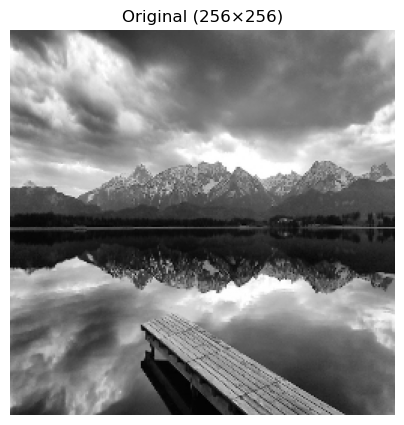

In [1]:
# %%
# Q10 — Low-pass / smoothing filters in the frequency domain
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load grayscale image (auto-resize to 256×256 for consistency) ---
img_path = "../image1.jpg"   # <- change path if needed
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    raise FileNotFoundError(img_path)
img_gray = cv2.resize(img_gray, (256, 256))
img = img_gray.astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("Original (256×256)")
plt.axis("off"); plt.show()


In [2]:
# %%
def fft2c(im):
    """Centered FFT (complex) + magnitude for visualization."""
    F  = np.fft.fft2(im)
    Fc = np.fft.fftshift(F)
    mag = np.log1p(np.abs(Fc))
    return Fc, mag

def ifft2c(Fc):
    """Inverse centered FFT → real image."""
    F  = np.fft.ifftshift(Fc)
    im = np.fft.ifft2(F).real
    return im

def meshgrid_radius(shape):
    """Matrix of distances to center (for radial filters)."""
    rows, cols = shape
    u = np.arange(rows) - rows//2
    v = np.arange(cols) - cols//2
    V, U = np.meshgrid(v, u)  # note order for (row,col)
    R = np.sqrt(U**2 + V**2)
    return R


In [3]:
# %%
def ideal_lpf(shape, D0):
    R = meshgrid_radius(shape)
    return (R <= D0).astype(np.float32)

def gaussian_lpf(shape, D0):
    R = meshgrid_radius(shape)
    # H(u,v) = exp(-(D^2)/(2*sigma^2)); with sigma=D0/√2 to interpret D0 as ~cutoff
    sigma = max(1e-6, D0/np.sqrt(2))
    return np.exp(-(R**2) / (2*sigma**2)).astype(np.float32)

def butterworth_lpf(shape, D0, n=2):
    R = meshgrid_radius(shape)
    eps = 1e-6
    return (1.0 / (1.0 + (R / max(D0,eps))**(2*n))).astype(np.float32)


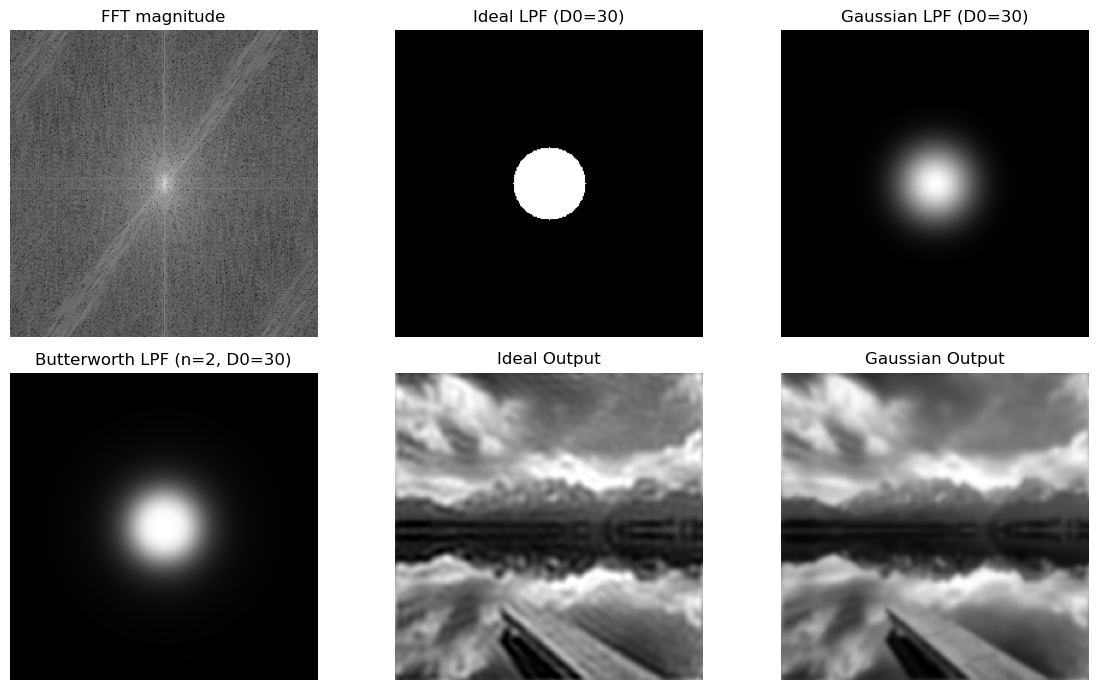

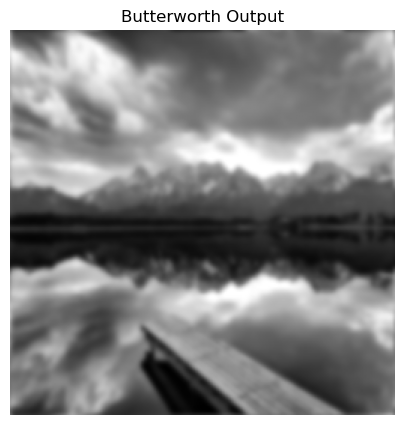

In [4]:
# %%
def apply_lpf(im, kind="gaussian", D0=30, order=2):
    Fc, mag = fft2c(im)
    if kind == "ideal":
        H = ideal_lpf(im.shape, D0)
    elif kind == "butter":
        H = butterworth_lpf(im.shape, D0, n=order)
    else:
        H = gaussian_lpf(im.shape, D0)
    Gc = Fc * H
    out = ifft2c(Gc)
    # normalize for display
    out_norm = np.clip(out, 0, 255)
    return out_norm.astype(np.uint8), H, mag

# quick demo with default parameters
g30, H_g30, mag = apply_lpf(img, kind="gaussian", D0=30)
i30, H_i30, _   = apply_lpf(img, kind="ideal",    D0=30)
b30, H_b30, _   = apply_lpf(img, kind="butter",   D0=30, order=2)

fig, ax = plt.subplots(2,3, figsize=(12,7))
ax[0,0].imshow(mag, cmap="gray"); ax[0,0].set_title("FFT magnitude"); ax[0,0].axis("off")
ax[0,1].imshow(H_i30, cmap="gray"); ax[0,1].set_title("Ideal LPF (D0=30)"); ax[0,1].axis("off")
ax[0,2].imshow(H_g30, cmap="gray"); ax[0,2].set_title("Gaussian LPF (D0=30)"); ax[0,2].axis("off")
ax[1,0].imshow(H_b30, cmap="gray"); ax[1,0].set_title("Butterworth LPF (n=2, D0=30)"); ax[1,0].axis("off")
ax[1,1].imshow(i30, cmap="gray");   ax[1,1].set_title("Ideal Output"); ax[1,1].axis("off")
ax[1,2].imshow(g30, cmap="gray");   ax[1,2].set_title("Gaussian Output"); ax[1,2].axis("off")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.imshow(b30, cmap="gray"); plt.title("Butterworth Output"); plt.axis("off"); plt.show()


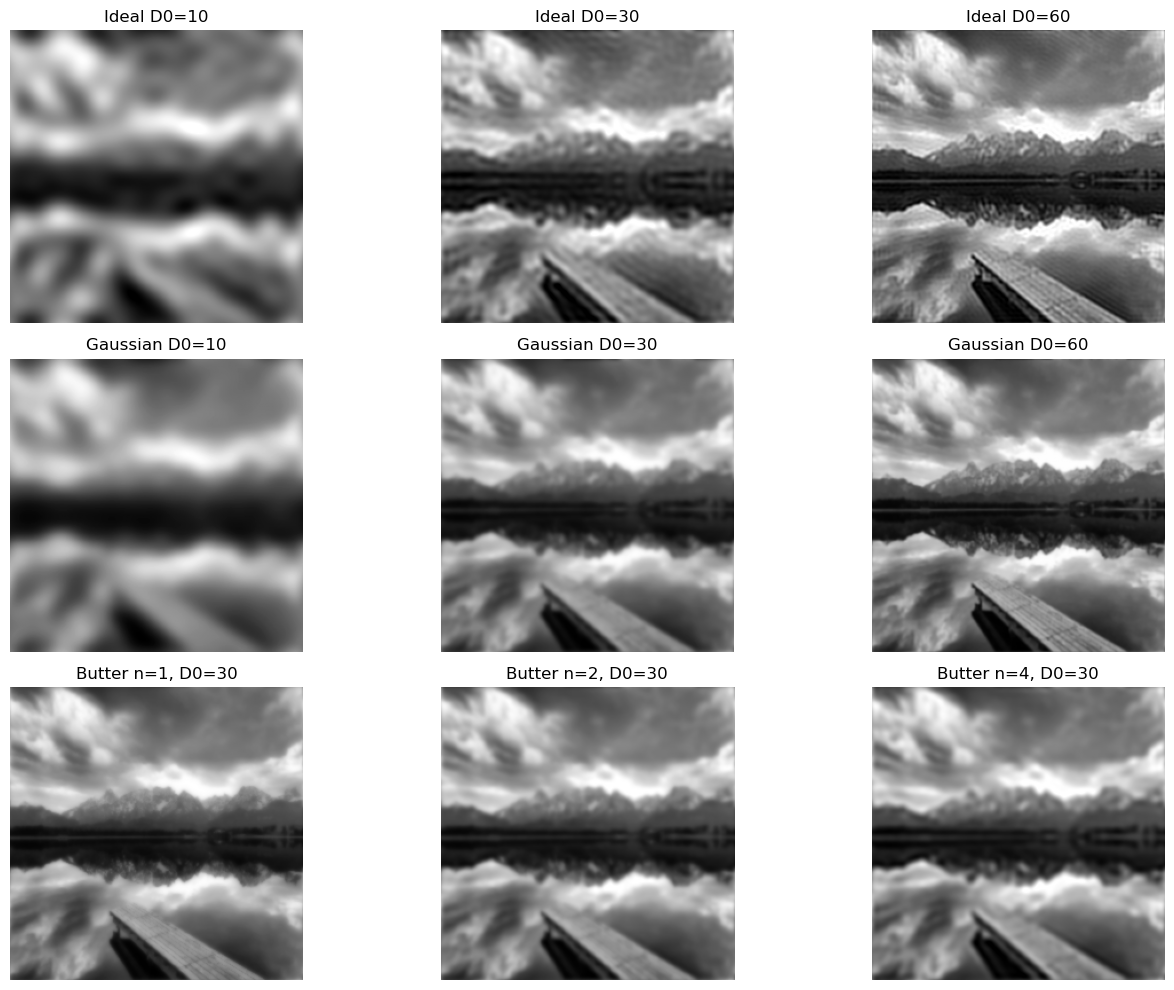

In [5]:
# %%
cutoffs = [10, 30, 60]        # increasing cutoff keeps more high frequencies → less blur
orders  = [1, 2, 4]           # for Butterworth

# Gaussian
gauss_imgs = [apply_lpf(img, "gaussian", D0=c)[0] for c in cutoffs]
# Ideal
ideal_imgs = [apply_lpf(img, "ideal", D0=c)[0] for c in cutoffs]
# Butterworth (try 3 orders at fixed cutoff)
butter_imgs = [apply_lpf(img, "butter", D0=30, order=n)[0] for n in orders]

fig, ax = plt.subplots(3, len(cutoffs), figsize=(14,10))
for j,c in enumerate(cutoffs):
    ax[0,j].imshow(ideal_imgs[j], cmap="gray"); ax[0,j].set_title(f"Ideal D0={c}"); ax[0,j].axis("off")
    ax[1,j].imshow(gauss_imgs[j], cmap="gray"); ax[1,j].set_title(f"Gaussian D0={c}"); ax[1,j].axis("off")
    ax[2,j].imshow(butter_imgs[1 if j==1 else 1], cmap="gray"); ax[2,j].axis("off")  # placeholder row
ax[2,0].set_title("Butter n=1, D0=30"); ax[2,0].imshow(butter_imgs[0], cmap="gray")
ax[2,1].set_title("Butter n=2, D0=30"); ax[2,1].imshow(butter_imgs[1], cmap="gray")
ax[2,2].set_title("Butter n=4, D0=30"); ax[2,2].imshow(butter_imgs[2], cmap="gray")
plt.tight_layout(); plt.show()


PSNR noisy   : 22.50 dB
PSNR Gaussian: 24.64 dB
PSNR Butter  : 25.34 dB


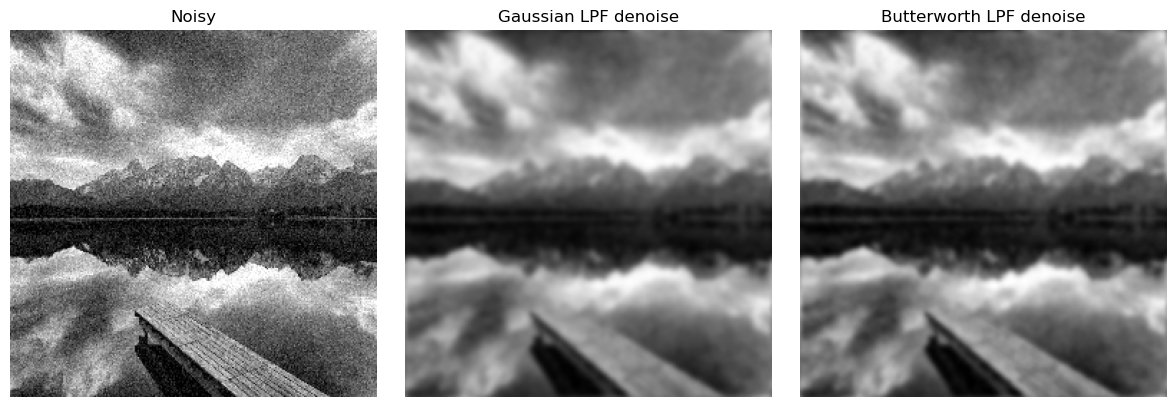

In [6]:
# %%
def add_gaussian_noise_u8(im_u8, sigma=15, seed=0):
    rng = np.random.default_rng(seed)
    noise = rng.normal(0, sigma, im_u8.shape).astype(np.int16)
    return np.clip(im_u8.astype(np.int16) + noise, 0, 255).astype(np.uint8)

def psnr(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    mse = np.mean((a-b)**2)
    return 99. if mse < 1e-12 else 10*np.log10((255**2)/mse)

orig_u8 = img.astype(np.uint8)
noisy   = add_gaussian_noise_u8(orig_u8, sigma=20, seed=42)

den_g = apply_lpf(noisy.astype(np.float32), "gaussian", D0=28)[0]
den_b = apply_lpf(noisy.astype(np.float32), "butter",  D0=28, order=2)[0]

print(f"PSNR noisy   : {psnr(orig_u8, noisy):.2f} dB")
print(f"PSNR Gaussian: {psnr(orig_u8, den_g):.2f} dB")
print(f"PSNR Butter  : {psnr(orig_u8, den_b):.2f} dB")

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(noisy, cmap="gray"); ax[0].set_title("Noisy"); ax[0].axis("off")
ax[1].imshow(den_g, cmap="gray"); ax[1].set_title("Gaussian LPF denoise"); ax[1].axis("off")
ax[2].imshow(den_b, cmap="gray"); ax[2].set_title("Butterworth LPF denoise"); ax[2].axis("off")
plt.tight_layout(); plt.show()
